In [39]:
import numpy as np
from project_helpers import gen_paths, payoff, bs_put, bs_call, d1
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from SemiStaticReplication import model
import keras
from tqdm import tqdm
import csv
import time


# %%
def save_details_to_csv(filename, details):
    with open(filename, 'a', newline='') as csvfile:
        fieldnames = details.keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Check if the file is empty and write the header only if it is
        csvfile.seek(0, 2)  # Move the cursor to the end of the file
        if csvfile.tell() == 0:
            writer.writeheader()

        writer.writerow(details)


# %%
class Portfolio:
    def __init__(self, cash=0, stock=0, pnl=0):
        self.cash = cash
        self.stock = stock
        self.pnl = pnl

    def add_cash(self, amount):
        self.cash += amount

    def add_interest(self, r, t):
        self.cash *= np.exp(r * t)

    def buy_stock(self, shares, stock_price):
        cost = shares * stock_price
        self.cash -= cost
        self.stock += shares

    def get_portfolio_value(self, stock_price):
        total_value = self.cash + (self.stock * stock_price)
        return total_value


# %%
def binomial_pricer(S0, strike, T_m, rfr, vol, n, exercise_dates, pf_style):
    m = len(exercise_dates) - 1
    dim = n * m

    dt = T_m / dim
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(rfr * dt) - d) / (u - d)

    option_values = np.zeros((dim + 1, dim + 1))

    i_values = np.arange(dim + 1)
    option_values[dim] = payoff(S0 * (u ** i_values) * (d ** (dim - i_values)), strike, pf_style)

    for t in range(dim - 1, -1, -1):

        i_values = np.arange(t + 1)  # Array [0, 1, ..., t]
        hold_values = np.exp(-rfr * dt) * (
                p * option_values[t + 1, i_values + 1] + (1 - p) * option_values[t + 1, i_values])

        if (t % n) != 0:
            option_values[t, : t + 1] = hold_values

        else:
            option_values[t, : t + 1] = np.maximum(hold_values,
                                                   payoff(S0 * (u ** i_values) * (d ** (t - i_values)), strike,
                                                          pf_style))

    return option_values


def delta_value_bermudan(s, strike, T_m, rfr, vol, n, exercise_dates, pf_style):
    option = binomial_pricer(s, strike, T_m, rfr, vol, n, exercise_dates, pf_style)
    v0 = option[0, 0]
    v1 = option[1, 1]
    v2 = option[1, 0]

    m = len(exercise_dates) - 1
    dim = n * m

    dt = T_m / dim
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u

    return (v1 - v2) / (s * (u - d)), v0


def delta_hedged_portfolio(stock_path, strike, T_m, rfr, vol, n, exercise_dates, pf_style):
    portfolio = Portfolio()

    s0 = stock_path[0]
    delta_0, v_0 = delta_value_bermudan(s0, strike, T_m, rfr, vol, n, exercise_dates, pf_style)

    portfolio.add_cash(v_0)
    portfolio.buy_stock(delta_0, s0)

    days_until_maturity = len(stock_path)
    dt = T_m / (days_until_maturity - 1)
    new_exercise_dates = exercise_dates

    tolerance = dt / 2

    for i in range(1, days_until_maturity):
        s_i = stock_path[i]
        new_exercise_dates = new_exercise_dates - dt
        new_exercise_dates = new_exercise_dates[new_exercise_dates > 0]
        new_exercise_dates = np.insert(new_exercise_dates, 0, 0.)

        new_T = new_exercise_dates[-1]
        delta_i, v_i = delta_value_bermudan(s_i, strike, new_T, rfr, vol, n, new_exercise_dates, pf_style)

        if (any(abs(i * dt - exercise_date) < tolerance for exercise_date in exercise_dates) & (strike - s_i > v_i)) or (
                i == days_until_maturity - 1):
            break

        portfolio.add_interest(rfr, dt)
        portfolio.buy_stock(delta_i - portfolio.stock, s_i)

    portfolio.add_interest(rfr, dt)
    portfolio.pnl = portfolio.get_portfolio_value(s_i) - payoff(s_i, strike, pf_style)

    return portfolio


def delta_hedged_european_bs_portfolio(stock_path, strike, T_m, rfr, vol, pf_style):
    portfolio = Portfolio()

    s0 = stock_path[0]
    v_0 = bs_put(np.array([s0]), np.array([strike]), T_m, rfr, vol)[0, 0]

    portfolio.add_cash(v_0)

    delta_0 = - norm.cdf(-d1(s0, strike, T_m, rfr, vol))

    portfolio.buy_stock(delta_0, s0)

    days_until_maturity = len(stock_path)
    dt = T_m / (days_until_maturity - 1)

    for i in range(1, days_until_maturity - 1):
        s_i = stock_path[i]

        portfolio.add_interest(rfr, dt)

        delta_i = - norm.cdf(-d1(s_i, strike, T_m - i * dt, rfr, vol))
        portfolio.buy_stock(delta_i - portfolio.stock, s_i)

    portfolio.add_interest(rfr, dt)
    portfolio.pnl = portfolio.get_portfolio_value(stock_path[-1]) - payoff(stock_path[-1], strike, pf_style)

    return portfolio


# %%

def cost_of_hedge(w_1, b_1, w_2, b_2, stock, delta_t, rfr, vol, normalizing_constant):
    normalized_stock = stock / normalizing_constant

    cost = b_2[0] * np.exp(-rfr * delta_t)

    mask1_indices = np.where((w_1 >= 0) & (b_1 >= 0))[0]
    mask2_indices = np.where((w_1 > 0) & (b_1 < 0))[0]
    mask3_indices = np.where((w_1 < 0) & (b_1 > 0))[0]

    strikes_call = -b_1[mask2_indices] / w_1[mask2_indices]
    strikes_put = -b_1[mask3_indices] / w_1[mask3_indices]

    cost += np.sum(w_2[mask1_indices] * (w_1[mask1_indices] *
                                         np.tile(normalized_stock[:, None], len(mask1_indices))
                                         + b_1[mask1_indices] * np.exp(-rfr * delta_t)), axis=1)[0]
    cost += np.sum(w_2[mask2_indices] * w_1[mask2_indices] *
                   bs_call(normalized_stock, strikes_call, delta_t, rfr, vol), axis=1)[0]
    cost -= np.sum(w_2[mask3_indices] * w_1[mask3_indices] *
                   bs_put(normalized_stock, strikes_put, delta_t, rfr, vol), axis=1)[0]

    return cost


def basket_payoff(w_1, b_1, w_2, b_2, stock_price_now, normalizing_constant):
    normalized_stock = stock_price_now / normalizing_constant
    mask1_indices = np.where((w_1 >= 0) & (b_1 >= 0))[0]
    mask2_indices = np.where((w_1 > 0) & (b_1 < 0))[0]
    mask3_indices = np.where((w_1 < 0) & (b_1 > 0))[0]

    strikes_call = -b_1[mask2_indices] / w_1[mask2_indices]
    strikes_put = -b_1[mask3_indices] / w_1[mask3_indices]

    total = b_2[0]
    total += np.sum(w_2[mask1_indices] * (w_1[mask1_indices] *
                                          normalized_stock
                                          + b_1[mask1_indices]))
    total += np.sum(w_2[mask2_indices] * (w_1[mask2_indices] *
                                          payoff(np.array([normalized_stock]), strikes_call, 'call')))
    total -= np.sum(w_2[mask3_indices] * (w_1[mask3_indices] *
                                          payoff(np.array([normalized_stock]), strikes_put, 'put')))

    return total


# semi-static hedge performance for the writer of the option
def semi_static_hedge(trained_weights, normalizing_sequence, dates, stock_path, premium, strike, rfr, vol, pf_style):
    portfolio = Portfolio()
    portfolio.add_cash(premium)

    n_mon = len(dates)
    differences = np.diff(dates)
    date_exercised = n_mon - 1
    for m in range(1, n_mon-1):
        normalizer = normalizing_sequence[m - 1]
        current_weights = trained_weights[- m]

        weights_layer_1 = np.array(current_weights[0]).reshape(-1)
        biases_layer_1 = np.array(current_weights[1])
        weights_layer_2 = np.array(current_weights[2]).reshape(-1)
        biases_layer_2 = np.array(current_weights[3])

        q = cost_of_hedge(weights_layer_1, biases_layer_1, weights_layer_2, biases_layer_2,
                          np.array([stock_path[m - 1]]), differences[m - 1], rfr, vol, normalizer)
        
        if strike - stock_path[m-1] > q:
            date_exercised = m-1
            break
        
        portfolio.add_cash(-q)

        portfolio.add_interest(rfr, differences[m - 1])
        portfolio.add_cash(
            basket_payoff(weights_layer_1, biases_layer_1, weights_layer_2, biases_layer_2, stock_path[m], normalizer))

    portfolio.pnl = portfolio.get_portfolio_value(stock_path[date_exercised]) - payoff(stock_path[date_exercised], strike, pf_style)
    return portfolio


# %%
def calculate_var(pnl_array, confidence_level=0.95):
    sorted_pnls = np.sort(pnl_array)
    confidence_index = int((1 - confidence_level) * len(sorted_pnls))

    var_value = sorted_pnls[confidence_index]

    return var_value


def calculate_cvar(pnl_array, confidence_level=0.95):
    sorted_pnls = np.sort(pnl_array)
    confidence_index = int((1 - confidence_level) * len(sorted_pnls))

    tail_losses = sorted_pnls[:confidence_index]

    # Calculate CVaR as the mean of the tail losses
    cvar_value = np.mean(tail_losses)

    return cvar_value

In [40]:
S = 40  # Initial stock price
K = 40  # Strike price
T = 1.0  # Time to maturity
r = 0.06  # Risk-free interest rate
sigma = 0.2  # Volatility
n = 30  # Number of time steps in the binomial tree
M = 10
style = 'put'
early_exercise_dates = tuple(int(j * 360 / M) for j in range(M + 1))  # List of early exercise dates
discretized_time = np.linspace(0, T, int(360 * T) + 1)
monitoring_dates = np.array([date / 360. for date in early_exercise_dates])
# %%
sample_size = 10000
sample_paths = gen_paths(discretized_time, S, r, sigma, sample_size)
hedging_error_Delta = np.zeros(sample_size, dtype=float)
hedging_error_Delta36 = np.zeros(sample_size, dtype=float)
hedging_error_Delta44 = np.zeros(sample_size, dtype=float)
for i in tqdm(range(sample_size)):
    hedging_error_Delta[i] = delta_hedged_portfolio(sample_paths[i], 40, T, r, sigma, n, monitoring_dates, style).pnl * 10000 / S
    hedging_error_Delta36[i] = delta_hedged_portfolio(sample_paths[i], 36, T, r, sigma, n, monitoring_dates, style).pnl * 10000 / S
    hedging_error_Delta44[i] = delta_hedged_portfolio(sample_paths[i], 44, T, r, sigma, n, monitoring_dates, style).pnl * 10000 / S
# %%
nodes = 64
N = 30000
weights, option_value, normalizers = model(S, K, r, sigma, N, monitoring_dates, style,
                                           keras.optimizers.Adam(), nodes, 0.001, 0.001)
v0 = option_value[0, 0]
print(v0)

100%|██████████| 10000/10000 [2:39:06<00:00,  1.05it/s] 


END OF FIRST PRE-RUN
2.36691296555625


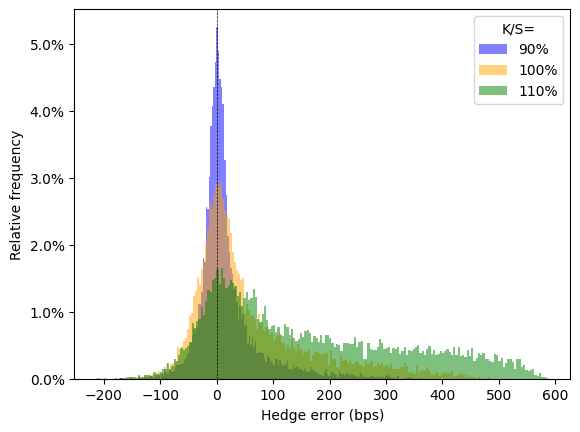

95% VaR Delta hedged portfolio: -51.3537979887155
95% CVaR Delta hedged portfolio: -75.95972684269131
95% VaR Delta hedged portfolio: -42.32743196402692
95% CVaR Delta hedged portfolio: -64.8708530535655
95% VaR Delta hedged portfolio: -43.84322473240364
95% CVaR Delta hedged portfolio: -72.76948409375592


In [41]:
fig, ax = plt.subplots()

# Plot histogram for hedging_error_Delta in orange with 50% transparency
ax.hist(hedging_error_Delta36, bins=200, color='blue', alpha=0.5,
       label='90%')
ax.hist(hedging_error_Delta, bins=200, color='orange', alpha=0.5,
       label='100%')
ax.hist(hedging_error_Delta44, bins=200, color='green', alpha=0.5,
       label='110%')

# Add legend
ax.legend(title='K/S=')

# Add vertical line at x=0
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

# Set x and y axis labels
plt.xlabel('Hedge error (bps)')
plt.ylabel('Relative frequency')

# Set y-axis as a percentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(sample_size))

# Save the plot to a file
plt.savefig(f'Hedging_Error_Comparison_{nodes}nodes_{S/K}moneyness{time.time()}.png', dpi=200, transparent=True)

# Show the plot
plt.show()

print(f'95% VaR Delta hedged portfolio: {calculate_var(hedging_error_Delta)}')
print(f'95% CVaR Delta hedged portfolio: {calculate_cvar(hedging_error_Delta)}')
print(f'95% VaR Delta hedged portfolio: {calculate_var(hedging_error_Delta36)}')
print(f'95% CVaR Delta hedged portfolio: {calculate_cvar(hedging_error_Delta36)}')
print(f'95% VaR Delta hedged portfolio: {calculate_var(hedging_error_Delta44)}')
print(f'95% CVaR Delta hedged portfolio: {calculate_cvar(hedging_error_Delta44)}')

END OF FIRST PRE-RUN


END OF FIRST PRE-RUN


END OF FIRST PRE-RUN
2.2928104059499828


100%|██████████| 10000/10000 [00:42<00:00, 234.41it/s]


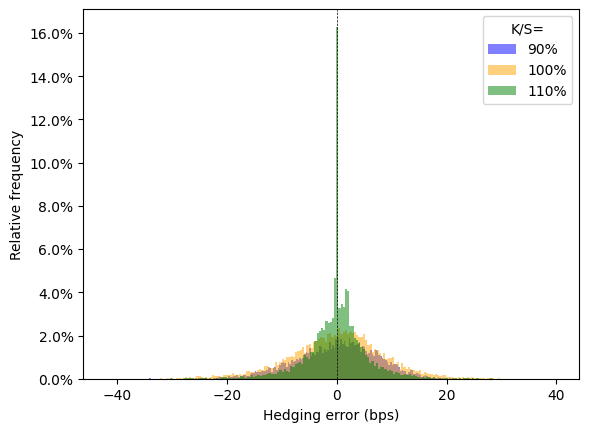

95% VaR semi-static hedged portfolio: -12.939543376294742
95% CVaR semi-static hedged portfolio: -16.291331196569697
-34.228263704007226
95% VaR semi-static hedged portfolio: -14.810502593620125
95% CVaR semi-static hedged portfolio: -19.94155937839639
-42.077704533107756
95% VaR semi-static hedged portfolio: -9.21798893442138
95% CVaR semi-static hedged portfolio: -14.119750638544083
-41.18485461966025


In [55]:
nodes = 16
N = 50000
S = 40
weights90, option_value90, normalizers90 = model(S, 36, r, sigma, N, monitoring_dates, style,
                                           keras.optimizers.Adam(), nodes, 0.001, 0.001)
weights100, option_value100, normalizers100 = model(S, 40, r, sigma, N, monitoring_dates, style,
                                           keras.optimizers.Adam(), nodes, 0.001, 0.001)
weights110, option_value110, normalizers110 = model(S, 44, r, sigma, N, monitoring_dates, style,
                                           keras.optimizers.Adam(), nodes, 0.001, 0.001)
v0 = option_value100[0, 0]
print(v0)

monitored_sample_path = sample_paths[:, early_exercise_dates]
hedging_error_SS90 = np.zeros(sample_size, dtype=float)
hedging_error_SS100 = np.zeros(sample_size, dtype=float)
hedging_error_SS110 = np.zeros(sample_size, dtype=float)
for i in tqdm(range(sample_size)):
    hedging_error_SS90[i] = semi_static_hedge(weights90, normalizers90, monitoring_dates, monitored_sample_path[i],
                                            option_value90[0, 0], 36, r, sigma, style).pnl * 10000 / S
    hedging_error_SS100[i] = semi_static_hedge(weights100, normalizers100, monitoring_dates, monitored_sample_path[i],
                                            option_value100[0, 0], 40, r, sigma, style).pnl * 10000 / S
    hedging_error_SS110[i] = semi_static_hedge(weights110, normalizers110, monitoring_dates, monitored_sample_path[i],
                                            option_value110[0, 0], 44, r, sigma, style).pnl * 10000 / S
# %%
# Plotting
fig, ax = plt.subplots()

# Plot histogram for hedging_error_SS in blue with 50% transparency
ax.hist(hedging_error_SS90, bins=200, color='blue', alpha=0.5,
        label=f'90%')
ax.hist(hedging_error_SS100, bins=200, color='orange', alpha=0.5,
        label=f'100%')
ax.hist(hedging_error_SS110, bins=200, color='green', alpha=0.5,
        label=f'110%')
# Add legend
ax.legend(title='K/S=')

# Add vertical line at x=0
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

# Set x and y axis labels
plt.xlabel('Hedging error (bps)')
plt.ylabel('Relative frequency')

# Set y-axis as a percentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(sample_size))

# Save the plot to a file
plt.savefig(f'Hedging_Error_Comparison_{nodes}nodes_{S/K}moneyness{time.time()}.png', dpi=200, transparent=True)

# Show the plot
plt.show()

# %%
print(f'95% VaR semi-static hedged portfolio: {calculate_var(hedging_error_SS90)}')
print(f'95% CVaR semi-static hedged portfolio: {calculate_cvar(hedging_error_SS90)}')
print(np.min(hedging_error_SS90))
print(f'95% VaR semi-static hedged portfolio: {calculate_var(hedging_error_SS100)}')
print(f'95% CVaR semi-static hedged portfolio: {calculate_cvar(hedging_error_SS100)}')
print(np.min(hedging_error_SS100))
print(f'95% VaR semi-static hedged portfolio: {calculate_var(hedging_error_SS110)}')
print(f'95% CVaR semi-static hedged portfolio: {calculate_cvar(hedging_error_SS110)}')
print(np.min(hedging_error_SS110))

# %%
details = {
    'S0': S,
    'K': K,
    'mu': r,
    'sigma': sigma,
    'monitoring_dates': monitoring_dates,
    'nodes': nodes,
    'number_of_sample_paths': sample_size,
    'loss_probability_Delta': np.mean(hedging_error_Delta < 0),
    'loss_probability_SS': np.mean(hedging_error_SS100 < 0),
    '95%_VaR_Delta': calculate_var(hedging_error_Delta),
    '95%_VaR_SS': calculate_var(hedging_error_SS100),
    '95%_CVaR_Delta': calculate_cvar(hedging_error_Delta),
    '95%_CVaR_SS': calculate_cvar(hedging_error_SS100)
}
save_details_to_csv('bermudan_hedging_details.csv', details)

nodes: 8
95% VaR Delta hedged portfolio: -0.19168626119651194
95% VaR semi-static hedged portfolio: -253.9211491465786
95% CVaR Delta hedged portfolio: -0.2905716525852994
95% CVaR semi-static hedged portfolio: -546.9152346603198
-1462.3031165855389

nodes: 16
95% VaR Delta hedged portfolio: -0.19168626119651194
95% VaR semi-static hedged portfolio: -260.9546052381676
95% CVaR Delta hedged portfolio: -0.2905716525852994
95% CVaR semi-static hedged portfolio: -551.5280318309154
-1485.5094000184404

nodes: 32
95% VaR Delta hedged portfolio: -0.19168626119651194
95% VaR semi-static hedged portfolio: -267.9986966885541
95% CVaR Delta hedged portfolio: -0.2905716525852994
95% CVaR semi-static hedged portfolio: -551.8752269189376
-1492.2005495788376

nodes: 64
95% VaR Delta hedged portfolio: -0.19168626119651194
95% VaR semi-static hedged portfolio: -268.3278900002743
95% CVaR Delta hedged portfolio: -0.2905716525852994
95% CVaR semi-static hedged portfolio: -551.728746740509
-1491.574189564294

95% VaR semi-static hedged portfolio: -5.043236736866566
95% CVaR semi-static hedged portfolio: -7.025438742357897
-23.952816324056034
95% VaR semi-static hedged portfolio: -3.2500030059257057
95% CVaR semi-static hedged portfolio: -4.304266343460301
-12.418538300283199
95% VaR semi-static hedged portfolio: -3.452487253111869
95% CVaR semi-static hedged portfolio: -4.947572381743892
-12.524682921491024

95% VaR semi-static hedged portfolio: -2.3834029003175656
95% CVaR semi-static hedged portfolio: -3.311922553368839
-13.804971342754111
95% VaR semi-static hedged portfolio: -11.515928453062774
95% CVaR semi-static hedged portfolio: -15.73006898371135
-43.58226100509771
95% VaR semi-static hedged portfolio: -1.9348519075674253
95% CVaR semi-static hedged portfolio: -3.312099264938068
-13.767525433918559

8 nodes:
95% VaR semi-static hedged portfolio: -22.801970360539112
95% CVaR semi-static hedged portfolio: -29.24834404458593
-70.4017702957851
95% VaR semi-static hedged portfolio: -59.48912300697667
95% CVaR semi-static hedged portfolio: -76.77310519447695
-169.19113142451093
95% VaR semi-static hedged portfolio: -60.52569745225112
95% CVaR semi-static hedged portfolio: -82.86098486979472
-187.63057722111446

32 nodes: 
95% VaR semi-static hedged portfolio: -13.448377401003906
95% CVaR semi-static hedged portfolio: -17.406080983214476
-32.815004620618254
95% VaR semi-static hedged portfolio: -6.13298211629831
95% CVaR semi-static hedged portfolio: -9.160467098519991
-22.392961467067472
95% VaR semi-static hedged portfolio: -5.248570290129911
95% CVaR semi-static hedged portfolio: -8.7540796994872
-32.84533889831968

32 nodes: 95% VaR semi-static hedged portfolio: -6.418971753331078
95% CVaR semi-static hedged portfolio: -8.252281187408203
-17.920383047882204
95% VaR semi-static hedged portfolio: -13.079628697384532
95% CVaR semi-static hedged portfolio: -17.89802879729797
-36.831001954776056
95% VaR semi-static hedged portfolio: -6.706148790831534
95% CVaR semi-static hedged portfolio: -9.62651615480302
-53.26315992223108